### QOSF Mentorship Challenge
#### Screening Task 1
`You have two integers, either positive or negative, and the challenge is to generate a quantum algorithm that returns which is the larger number.`
<hr />

At first glance, the situation appears to be simple. Create a system after with qubit (initialized as) in a superposition of computational bases states with the specified integers as normalized amplitudes. Measure the system a large number of times to obtain enough statistics, and there you have it! You can determine the larger of the two values by examining the probabilities with which each computational state is observed. But is the task really that trivial? <br>

Nope. This method faces two distinct problems:

1. How can we discern between positive and negative integers? 
<br> We know that for a given state $|\psi\rangle = \alpha |0\rangle + \beta|1\rangle$, the probability of observing $|0\rangle$ is $\left|\frac{\alpha}{\sqrt{\alpha^2 + \beta^2}}\right|^2$ whereas the probability of observing $|1\rangle$ is $\left|\frac{\beta}{\sqrt{\alpha^2 + \beta^2}}\right|^2$. Because probability must be strictly positive, we have no means of knowing whether $\alpha$ or $\beta$ are positive or negative.

2. How large is large enough?
<br> We know that the aforementioned probabilities will approach their theoretical value only when $N \to \infty$ number of measurements are made. This is very expensive! Moreover, if the given numbers are large and are close together, the chance of observing either $|0\rangle$ or $|1\rangle$ will be almost equal i.e. probabilities will approach $1/2$. Thus, in order to tell the difference, we would need to even larger number of measurements. <br>

This challenge, however, is not insoluble. To get around the problems discussed above, we can use the well-known "Bernstein-Vazirani Algorithm" [1] and [2].


<hr />

#### Strategy
Assume we have two integers, $a$ and $b$. We can create two new variables, let's call them $A$ and $B$, and define them as follows: <br>
$$A = \text{int}\left (\frac{a}{\text{max}(a, b)}\right ) \text{ and } B = \text{int}\left (\frac{b}{\text{max}(a, b)} \right ).$$

Given the above definition, it is obvious that at least one of $A$ or $B$ must be $1$. The solution to our initial challenge is to determine which of $A$ or $B$ is $1$.

> Aside: What about the other variable? Is it required to be 0? <br>
Now, in essence, what we are trying to accomplish is to map the larger of the two values to 1 and the smaller one to 0. However, it is not straightforward to do that. Moreover, the transformation will not be unitary. To get around this problem, we can ensure that the larger number gets mapped to 1 without restricting the image of the smaller number. As we will see, this has little to no effect on our final computation. We perform this transformation to tackle the first problem stated above.

As previously stated, we will apply the "Bernstein-Vazirani Algorithm" to determine which of $A$ or $B$ is $1$.
<hr />

In [1]:
'''libraries'''
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from qiskit.visualization import plot_histogram
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, IBMQ, execute

'''loading account and info.'''
account = IBMQ.load_account()
provider = IBMQ.providers()
provider = IBMQ.get_provider("ibm-q")

'''setting parameters for quantum hardware'''
sim = Aer.get_backend('aer_simulator')
device = least_busy(provider.backends(filters=lambda x: int(x.configuration().n_qubits) >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))

To solve this problem, we will use the standard BV oracle with a minor tweak. In a typical BV problem, we know the secret key and construct our oracle accordingly. In this case, however, we will use conditional statements in the Oracle to determine the control and ancilla qubits for the CNOT gate. It is because of this conditional statement, we can conclude that mapping a smaller number to $0$ is not required to produce correct results because phase kickback alters the relative phase of the variable that represents the larger number, i.e. the variable which is $1$.

In [2]:
def bv_circuit(a, b):
    try:
        A = int(a/max(a, b))
        B = int(b/max(a, b))
    except ZeroDivisionError:
        '''Answer is 0; No "return(0)" to avoid inconsistent format of return'''
        A = 1
        B = 1

    q = QuantumRegister(3, "q")
    c = ClassicalRegister(2, "c")
    qc = QuantumCircuit(q, c)
    
    # circuit
    qc.x(2)
    qc.barrier()
    qc.h(0)
    qc.h(1)
    qc.h(2)
    '''conditional CNOT'''
    if(A == 1):
        qc.cx(0, 2)
    elif(B == 1):
        qc.cx(1, 2)
    qc.h(0)
    qc.h(1)
    qc.h(2)
    qc.barrier()

    qc.measure([0, 1],[0, 1])

    return qc

After obtaining the results, we can treat '$AB$' as the binary index of the larger element in the list.

In [3]:
def find_largest(a, b, system = sim, circ = False):
    ls = [a, b]
    _circ = bv_circuit(a, b)
    if(circ == True):
        _circ.draw(output='mpl', style={'backgroundcolor': '#EEEEEE'})
    result = execute(_circ, backend = system, shots = 1024).result()
    counts = result.get_counts()
    plot_histogram(counts)
    out_bit = max(counts, key = lambda x: counts[x])
    
    return(ls[int(out_bit, 2)-1])

Let's see if our strategy works as expected.
#### Example 1: $a$ is positive and $b$ is negative
$a = 3$, $b = -1$ <br>
On Simulator

Larger of the two numbers is:  3


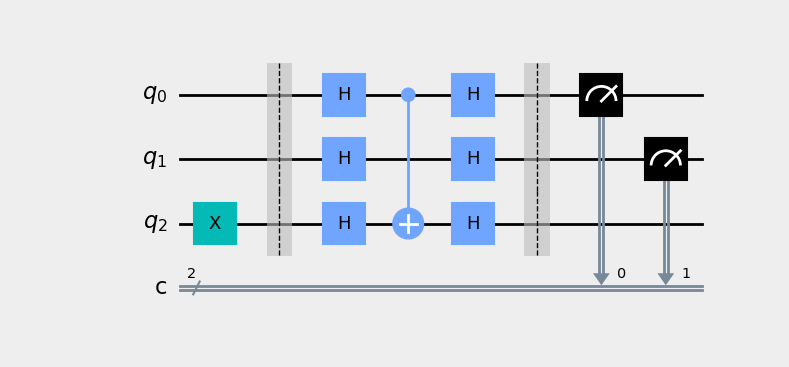

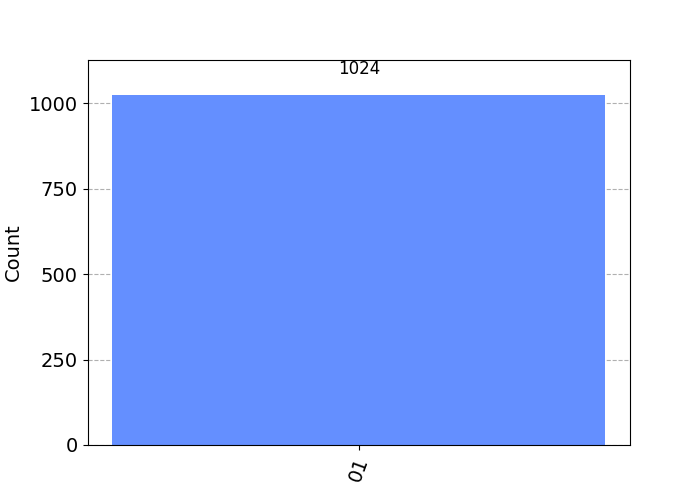

In [4]:
answer = find_largest(3, -1, sim, circ = True)
print("Larger of the two numbers is: ", answer)

On Real Device: ibmq_jakarta

Larger of the two numbers is:  3


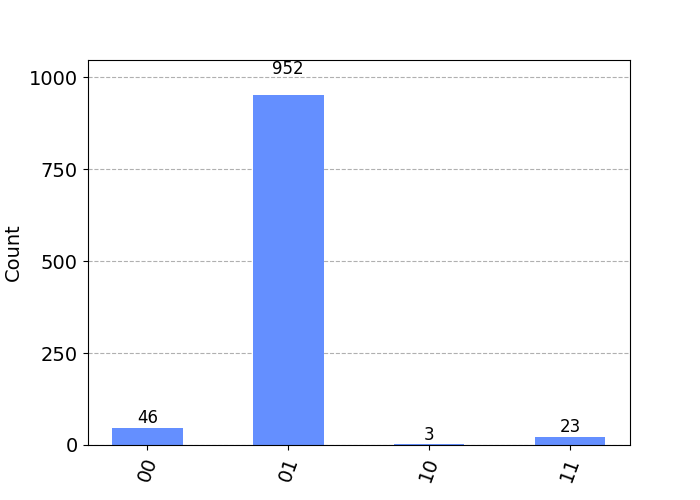

In [5]:
answer = find_largest(3, -1, device)
print("Larger of the two numbers is: ", answer)

It is evident that the counts in '$00$' and '$11$' are simply due to system noise. As a result, it is evident that our method is quite effective.

We can see that our approach works effectively when $a$ is positive and $b$ is negative positive. <br>
Let us check it for other cases as well. <br>

#### Example 2: Both $a$ and $b$ are positive
$a = 4$, $b = 10$

Larger of the two numbers is:  10


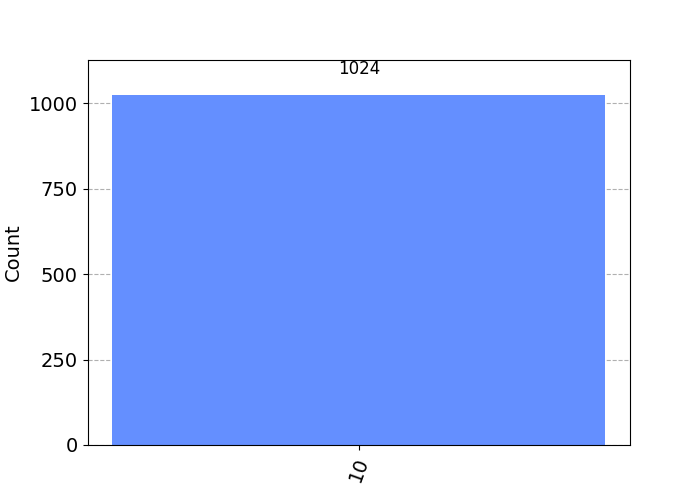

In [6]:
answer = find_largest(4, 10, sim)
print("Larger of the two numbers is: ", answer)

#### Example 3: $a$ is negative and $b$ are positive
$a = -19$, $b = 2$

Larger of the two numbers is:  2


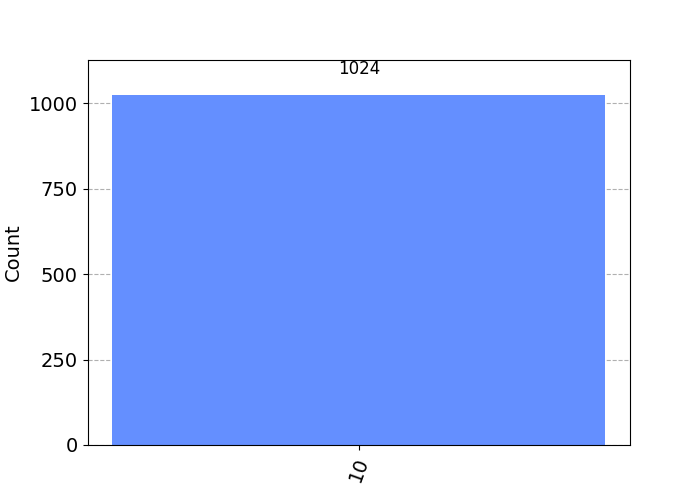

In [7]:
answer = find_largest(-19, 2, sim)
print("Larger of the two numbers is: ", answer)

#### Example 4: Both $a$ are $b$ are negative
$a = -7$, $b = -11$

Larger of the two numbers is:  -7


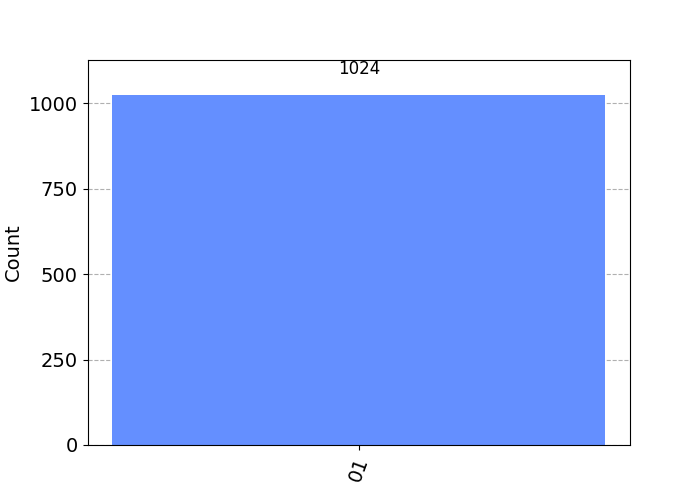

In [8]:
answer = find_largest(-7, -11, sim)
print("Larger of the two numbers is: ", answer)

Our algorithm performs well. It won't hurt to try if it works with real numbers as well <br>
#### Example 4: Both $a$ and $b$ are real numbers
$a = \pi$, $b = e$

Larger of the two numbers is:  3.141592653589793


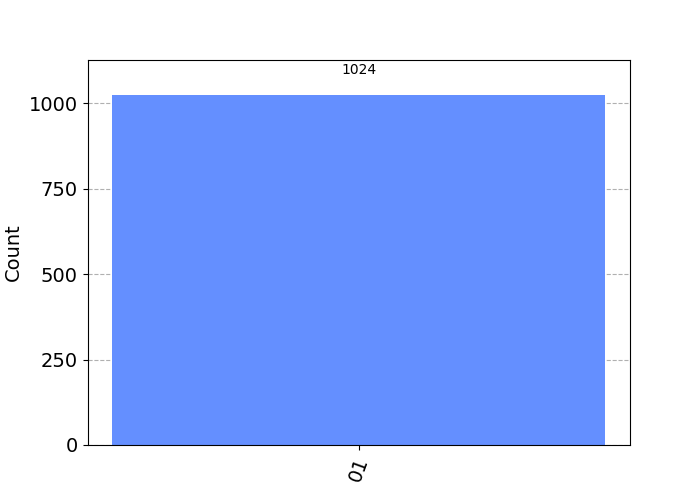

In [9]:
answer = find_largest(np.pi, np.exp(1), sim)
print("Larger of the two numbers is: ", answer)

#### Example 5: Both $a$ and $b$ are large
$a = 10^{70}+1$, $b = 10^{70}-1$

Larger of the two numbers is:  10000000000000000000000000000000000000000000000000000000000000000000001


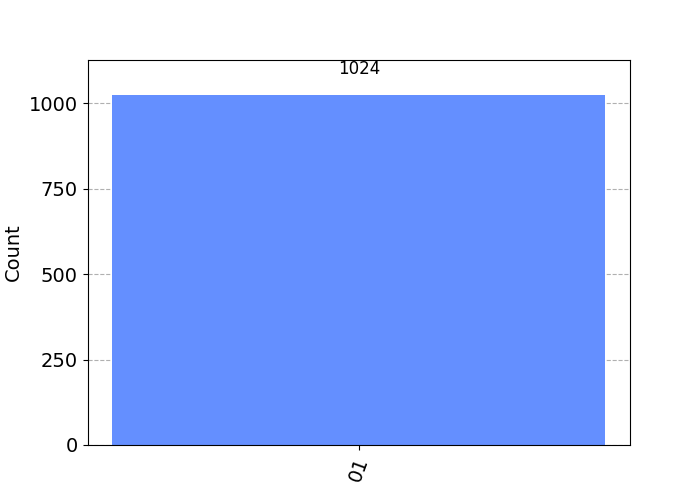

In [10]:
answer = find_largest(10**70+1, 10**70-1, sim)
print("Larger of the two numbers is: ", answer)

As a consequence of this result, we can deduce that our approach is also effective against the second problem listed above, as it can easily distinguish between large yet close integers.
<hr />

### What comes next?
If we examine closely, we can see that we did not fully exploit the possibilities by using other, more effective quantum algorithms such as Grover's Search Algorithm [3] or the HLF Algorithm. It will be interesting to investigate the problem more with these methods in the future.
<hr />

### References

1. [Bernstein-Vazirani's Algorithm, Qiskit Textbooks, IBM Quantum](https://qiskit.org/textbook/ch-algorithms/bernstein-vazirani.html)
2. [One Try: QC Explained (an amazing medium post on BV Algorithm)](https://medium.com/nerd-for-tech/one-try-qc-explained-5b466c199616#:~:text=The%20Bernstein%20Vazirani%20algorithm%20leverages,whole%20number%20in%20one%20try.)
3. [Grover's Algorithm, Qiskit Textbooks, IBM Quantum](https://qiskit.org/textbook/ch-algorithms/grover.html)
4. Quantum Computation and Quantum Information, *M. Neilson* and *I. Chuang*